In [1]:
import numpy as np
from pycbf import CPUCoherenceBeamformer
from pycbf import CPUBeamformer
import matplotlib.pyplot as plt
import timuscle.beamforming as tibf
import timuscle.dataio as dio
from scipy.signal import hilbert, coherence

In [2]:
path = "/home/wew12/data/invivo/RawData/"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230512_P003_v2/acq_06_flex_42_pushfocus_25mm/RawData"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230519_P006/acq_05_kf_43_vl_L/RawData"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230421_V001/acq_2_flex_45_musc_vl/RawData"

rf, dims, params = dio.verasonics_loadbmoderf(path)

t = dims['t_sec']

c = params['c']
f = params['f']
lam = c/f

na = int(params['track_params']['rf']['na'])
dtheta = params['track_params']['rf']['dtheta']

steers = dtheta * (np.arange(na) - (na-1)/2)

nele = int(params['trans']['nele'])
dele = params['trans']['dele']
xele = dele * (np.arange(nele) - (nele-1)/2)

fnum = 0.8

xout, zout = tibf.make_recon_grid_by_BW_2D(
    fnum = fnum,
    lam = lam,
    xmin = -20E-3,
    xmax = 20E-3,
    zmin = 1E-3,
    zmax = 50E-3
)

tautx, taurx, apodtx, apodrx = tibf.make_tabs_and_apods_pw_2D(
    steers=steers,
    c=c,
    xele=xele,
    xout=xout,
    zout=zout,
    fnum=1
)

In [3]:
bmfrm = CPUCoherenceBeamformer(
    tautx=tautx,
    taurx=taurx,
    apodtx=apodtx,
    apodrx=apodrx,
    t0 = t[0],
    dt = t[1]-t[0],
    nt = len(t)
)

In [11]:
im = bmfrm(rf[:,12+18,:,:].transpose(1, 0, 2)).reshape(-1,len(xout), len(zout))

100%|██████████| 128/128 [00:11<00:00, 11.35it/s]


In [5]:
def calc_coherence(subset):
    # subtract the mean of each aline
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    # caculate the lag-n coherence
    rhos = np.zeros(len(sig)-1)
    for lag in range(subset.shape[1]-1):
        cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
        rhos[lag] = np.mean(cross / (sig[:n-lag] * sig[lag:]))
    
    return rhos

def calc_lagn_coherence(subset, lag:int):
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
    return np.mean(cross / (sig[:n-lag] * sig[lag:]))

In [6]:
apodrx_coherence = apodrx.reshape(-1, len(xout), len(zout))

In [7]:
from tqdm.notebook import tqdm

  0%|          | 0/170 [00:00<?, ?it/s]

/tmp/ipykernel_75019/2663387294.py:21: RuntimeWarning: invalid value encountered in divide
  return np.mean(cross / (sig[:n-lag] * sig[lag:]))


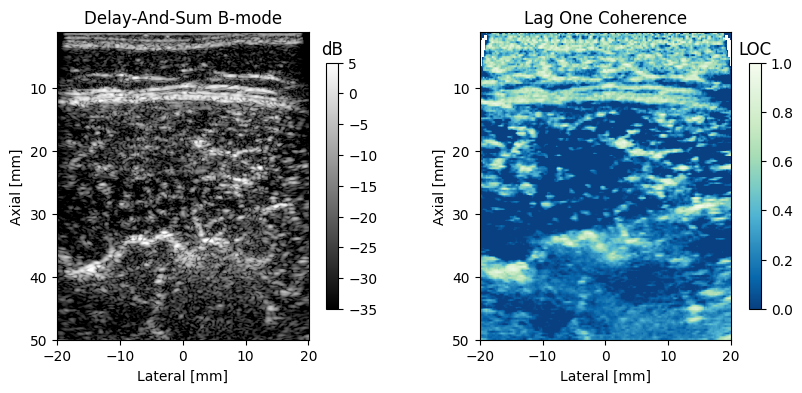

In [8]:
dz = zout[1]-zout[0]
nkern = int(np.ceil(0.5 * lam / (dz)/2))
dsfx = 2
dsfz = 4*dsfx

loc = np.zeros((1+xout.size//dsfx, 1+zout.size//dsfz))
for ix in tqdm(range(0, xout.size, dsfx)):
    for iz in range(0, zout.size, dsfz):
        izmin = np.max([0, iz-nkern])
        izmax = np.min([zout.size, iz+nkern+1])

        mask = apodrx_coherence[:,ix,izmin:izmax]
        elesel = np.sum(mask, axis=-1) == mask.shape[-1]

        if np.sum(elesel) < 2: continue

        channels = im[elesel,ix,izmin:izmax]

        loc[ix//dsfx,iz//dsfz] = calc_lagn_coherence(channels.T, 1)

ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
ax = axes[1]
pltim = ax.imshow(loc.T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Lag One Coherence")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("LOC")

env = np.abs(hilbert(np.sum(im, axis=0), axis=-1)).T
logged = 20 * np.log10(env/np.percentile(env, 99))

ax = axes[0]
pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Delay-And-Sum B-mode")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")
plt.show()

In [9]:
dz = zout[1]-zout[0]
nlam  = 0.5
nhalf = int(np.ceil(nlam * lam / (dz)/2))

im.shape, apodrx_coherence.shape

istart = int(0)
cohers = []
for lag in range(1,31):
    nkern  = 1 + 2*nhalf
    nstck  = int((im.shape[-1]-istart)//nkern)
    axsel  = slice(istart, istart + nstck*nkern)

    shape  = (apodrx_coherence.shape[0], apodrx_coherence.shape[1], nstck, nkern)
    mask   = apodrx_coherence[:,:,axsel].reshape(shape)
    subset = im[:,:,axsel].reshape(shape)
    subset = subset - np.mean(subset, axis=-1, keepdims=True)

    has_nkern = np.sum(mask, axis=-1) == nkern

    sig0  = np.std(subset[:-lag], axis=-1)
    sig1  = np.std(subset[lag :], axis=-1)
    cross = np.mean(subset[:-lag] * subset[lag :], axis=-1)
    valid = has_nkern[:-lag] & has_nkern[lag :] 
    valid &= np.sum(valid, axis=0, keepdims=True) >=8

    rhos = cross / (sig0 * sig1)
    rhos[~valid] = np.nan
    coher = np.nanmean(rhos, axis=0)
    cohers.append(coher)

cohers=np.array(cohers)

/tmp/ipykernel_75019/2313307074.py:27: RuntimeWarning: invalid value encountered in divide
  rhos = cross / (sig0 * sig1)
/tmp/ipykernel_75019/2313307074.py:29: RuntimeWarning: Mean of empty slice
  coher = np.nanmean(rhos, axis=0)


/tmp/ipykernel_75019/209383329.py:10: RuntimeWarning: Mean of empty slice
  slsc = np.nanmean(cohers[:10], axis=0)


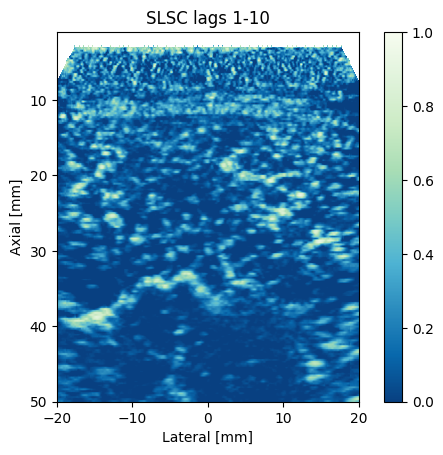

In [10]:
# for icoher, coher in enumerate(cohers):
#     plt.figure()
#     plt.imshow(coher.T, extent=ex_axlat, cmap='GnBu_r', vmin=0, vmax=1)
#     plt.title(f"Lag {icoher+1} Coherence")
#     plt.colorbar()
#     plt.xlabel("Lateral [mm]")
#     plt.ylabel("Axial [mm]")
#     plt.show()

slsc = np.nanmean(cohers[:10], axis=0)

plt.figure()
plt.imshow(slsc.T, extent=ex_axlat, cmap='GnBu_r', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel("Lateral [mm]")
plt.ylabel("Axial [mm]")
plt.title("SLSC lags 1-10")
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


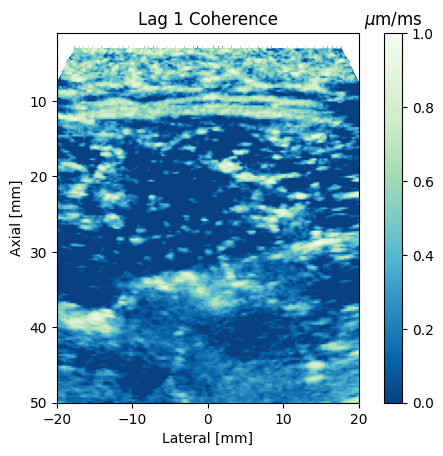

In [85]:
from matplotlib.animation import FuncAnimation

ilagsel = 0
fig, ax = plt.subplots(1,1)
axim = ax.imshow(cohers[ilagsel].T, vmin=0, vmax=1, extent=ex_axlat, cmap='GnBu_r')
plt.colorbar(axim, ax=ax).ax.set_title("$\\mu$m/ms")
ax.set_title(f"Lag {ilagsel+1} Coherence")
ax.set_xlabel("Lateral [mm]")
ax.set_ylabel("Axial [mm]")

def plotit(ilagsel, ax):
    ax.clear()
    ax.imshow(cohers[ilagsel].T, vmin=0, vmax=1, extent=ex_axlat, cmap='GnBu_r')
    ax.set_title(f"Lag {ilagsel+1} Coherence")
    ax.set_xlabel("Lateral [mm]")
    ax.set_ylabel("Axial [mm]")

    return ax,

ani = FuncAnimation(fig, plotit, np.arange(cohers.shape[0]-1, dtype=int), fargs=(ax,))

ani.save(
    f"slsc.gif",
    fps=2
)

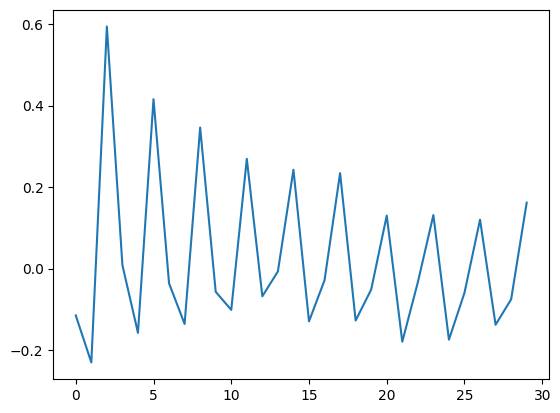

In [86]:
plt.figure()
plt.plot(cohers[:,cohers.shape[1]//2,cohers.shape[2]//2])
plt.show()